In [337]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, abs, avg, lag, desc
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
spark = SparkSession.builder.appName('Stock Data').getOrCreate()

Loading file in dataframe

In [338]:
dataset = spark.read.csv('AMZN.csv', inferSchema=True, header=True)

In [339]:
dataset.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [340]:
dataset.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)



In [341]:
dataset.show()

+----------+--------+--------+--------+--------+---------+----------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|
+----------+--------+--------+--------+--------+---------+----------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|
|1997-05-22|0.071875|0.072396|0.065625|0.069792| 0.069792| 235536000|
|1997-05-23|0.070313|0.076042|0.066667|   0.075|    0.075| 318744000|
|1997-05-27|0.075521|0.082292|0.072917|0.079167| 0.079167| 173952000|
|1997-05-28| 0.08125|0.081771|0.076563|0.076563| 0.076563|  91488000|
|1997-05-29|0.077083|0.077083|0.073958| 0.07526|  0.07526|  69456000|
|1997-05-30|   0.075|0.075521|0.073958|   0.075|    0.075|  51888000|
|1997-06-02|0.075521

In [342]:
null_checks = [count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]
dataset.select(null_checks).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



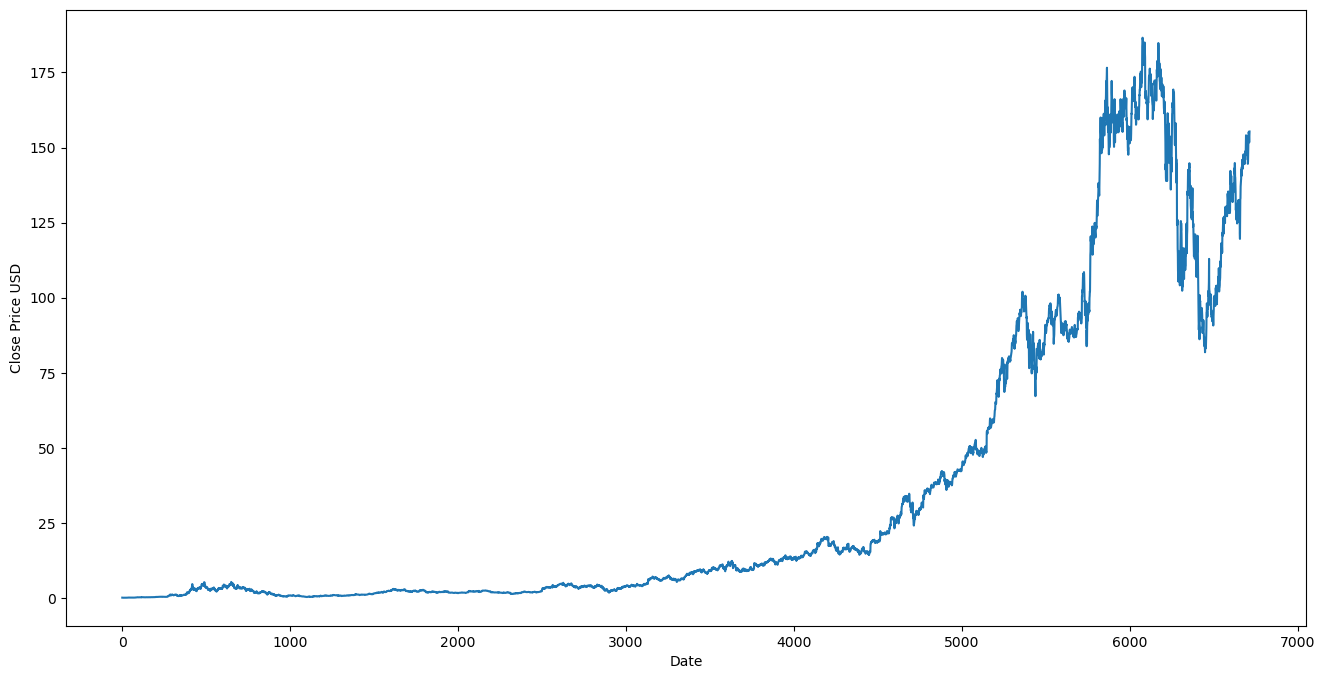

In [343]:
pandas_df = dataset.select('Date', 'Close').toPandas()
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df['Close'])
plt.show()

In [344]:
future_days=7
windowSpec = Window.orderBy("Date")
dataset = dataset.withColumn("Future_close", lag("Close", -future_days).over(windowSpec))
dataset.show(5)

+----------+--------+--------+--------+--------+---------+----------+------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|Future_close|
+----------+--------+--------+--------+--------+---------+----------+------------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|    0.079167|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|    0.076563|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|     0.07526|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|       0.075|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|    0.075521|
+----------+--------+--------+--------+--------+---------+----------+------------+
only showing top 5 rows



In [345]:
dataset.orderBy(desc("Date")).show(5)

+----------+----------+----------+----------+----------+----------+--------+------------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|Future_close|
+----------+----------+----------+----------+----------+----------+--------+------------+
|2024-01-19|153.830002|155.759995|152.740005|155.339996|155.339996|51033700|        NULL|
|2024-01-18|152.770004|153.779999|151.820007|     153.5|     153.5|37850200|        NULL|
|2024-01-17|151.490005|152.149994|149.910004|151.710007|151.710007|34953400|        NULL|
|2024-01-16|153.529999|154.990005|152.149994|153.160004|153.160004|41384600|        NULL|
|2024-01-12|155.389999|156.199997|154.009995|154.619995|154.619995|40460300|        NULL|
+----------+----------+----------+----------+----------+----------+--------+------------+
only showing top 5 rows



In [346]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [347]:
featureassembler=VectorAssembler(inputCols=["Open", "High", "Low"], outputCol='Features')

In [348]:
output=featureassembler.transform(dataset)

In [349]:
null_checks = [count(when(col(c).isNull(), c)).alias(c) for c in output.columns]
output.select(null_checks).show()

+----+----+----+---+-----+---------+------+------------+--------+
|Date|Open|High|Low|Close|Adj Close|Volume|Future_close|Features|
+----+----+----+---+-----+---------+------+------------+--------+
|   0|   0|   0|  0|    0|        0|     0|           7|       0|
+----+----+----+---+-----+---------+------+------------+--------+



In [350]:
output = output.na.drop()

In [351]:
output.show()

+----------+--------+--------+--------+--------+---------+----------+------------+--------------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|Future_close|            Features|
+----------+--------+--------+--------+--------+---------+----------+------------+--------------------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|    0.079167|[0.121875,0.125,0...|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|    0.076563|[0.098438,0.09895...|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|     0.07526|[0.088021,0.08854...|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|       0.075|[0.086458,0.0875,...|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|    0.075521|[0.081771,0.08229...|
|1997-05-22|0.071875|0.072396|0.065625|0.069792| 0.069792| 235536000|    0.073958|[0.071875,0.07239...|
|1997-05-23|0.070313|0.076042|0.066667|   0.075|    0.075| 31874

In [352]:
output.select(['Features']).show()

+--------------------+
|            Features|
+--------------------+
|[0.121875,0.125,0...|
|[0.098438,0.09895...|
|[0.088021,0.08854...|
|[0.086458,0.0875,...|
|[0.081771,0.08229...|
|[0.071875,0.07239...|
|[0.070313,0.07604...|
|[0.075521,0.08229...|
|[0.08125,0.081771...|
|[0.077083,0.07708...|
|[0.075,0.075521,0...|
|[0.075521,0.07656...|
|[0.076563,0.07656...|
|[0.073958,0.07447...|
|[0.070833,0.07708...|
|[0.075781,0.08541...|
|[0.082813,0.08541...|
|[0.085417,0.08541...|
|[0.079688,0.08020...|
|[0.079167,0.08229...|
+--------------------+
only showing top 20 rows



In [353]:
output.columns

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Future_close',
 'Features']

In [354]:
final_data=output.select("Date", "Features", "Close", "Future_Close").sort("Date", ascending=True)

In [355]:
final_data.show()

+----------+--------------------+--------+------------+
|      Date|            Features|   Close|Future_Close|
+----------+--------------------+--------+------------+
|1997-05-15|[0.121875,0.125,0...|0.097917|    0.079167|
|1997-05-16|[0.098438,0.09895...|0.086458|    0.076563|
|1997-05-19|[0.088021,0.08854...|0.085417|     0.07526|
|1997-05-20|[0.086458,0.0875,...|0.081771|       0.075|
|1997-05-21|[0.081771,0.08229...|0.071354|    0.075521|
|1997-05-22|[0.071875,0.07239...|0.069792|    0.073958|
|1997-05-23|[0.070313,0.07604...|   0.075|    0.070833|
|1997-05-27|[0.075521,0.08229...|0.079167|    0.077083|
|1997-05-28|[0.08125,0.081771...|0.076563|    0.082813|
|1997-05-29|[0.077083,0.07708...| 0.07526|    0.084375|
|1997-05-30|[0.075,0.075521,0...|   0.075|    0.079167|
|1997-06-02|[0.075521,0.07656...|0.075521|    0.077083|
|1997-06-03|[0.076563,0.07656...|0.073958|    0.080208|
|1997-06-04|[0.073958,0.07447...|0.070833|    0.079167|
|1997-06-05|[0.070833,0.07708...|0.077083|    0.

In [356]:
train_data, test_data=final_data.randomSplit([0.75,0.25])
print(f"""There are {train_data.count()} rows in the trainning set,
      and {test_data.count()} in the test set""")

There are 5052 rows in the trainning set,
      and 1655 in the test set


Linear Regression model

In [357]:
from pyspark.ml.regression import LinearRegression

In [358]:
regressor=LinearRegression(featuresCol='Features', labelCol='Future_Close')
lr_model=regressor.fit(train_data)

In [359]:
lr_model.coefficients

DenseVector([-0.6166, 0.8285, 0.7881])

In [360]:
lr_model.intercept

0.16142899610905145

Test

In [361]:
pred_test1=lr_model.transform(test_data)
pred_test1.select("Features", "Close", "Future_Close", "Prediction").show(30)

+--------------------+--------+------------+-------------------+
|            Features|   Close|Future_Close|         Prediction|
+--------------------+--------+------------+-------------------+
|[0.08125,0.081771...|0.076563|    0.082813|0.23941423909552267|
|[0.077083,0.07708...| 0.07526|    0.084375|0.23604668985033414|
|[0.075521,0.07656...|0.075521|    0.077083| 0.2374001141770031|
|[0.079688,0.08020...|0.077083|    0.076302|0.23908240832979144|
|[0.080208,0.08020...|0.078646|    0.075521|0.23999273824542727|
|[0.079948,0.07994...| 0.07526|    0.075521|0.23727007019908491|
|[0.076042,0.07682...|0.075521|    0.074479|  0.237294286765752|
|[0.075521,0.07656...|0.075521|    0.077083| 0.2374001141770031|
|[0.076563,0.07760...|0.076302|    0.075781|0.23762009516759347|
|[0.079948,0.09583...|0.095573|    0.121875| 0.2543297100026086|
|[0.091667,0.10104...|     0.1|    0.116667| 0.2608598285058577|
|[0.126042,0.12604...|0.114583|    0.106771| 0.2751533121715065|
|[0.106771,0.12395...|0.1

In [362]:
from pyspark.ml.evaluation import RegressionEvaluator

In [363]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Future_Close", metricName="mse")
mse = evaluator.evaluate(pred_test1)
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Future_Close", metricName="r2")
r2 = evaluator_r2.evaluate(pred_test1)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  12.985174186491061 
r2:  0.9949571276175966 



In [364]:
pred_test1=pred_test1.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_test1.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  11.815015827805356


In [365]:
pandas_df1 = pred_test1.select("Close", "Future_Close", "Prediction").toPandas()

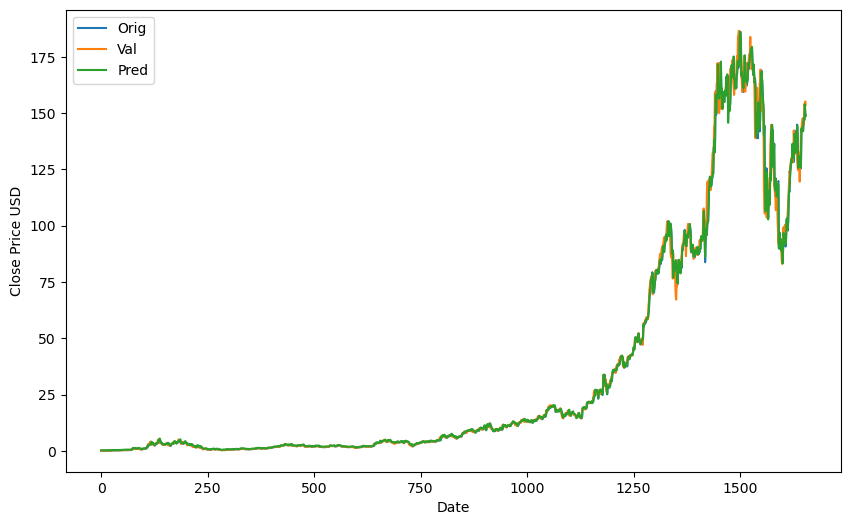

In [366]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df1['Close'])
plt.plot(pandas_df1[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Train

In [367]:
pred_train1=lr_model.transform(train_data)
pred_train1.select("Features", "Close", "Future_Close", "Prediction").show()

+--------------------+--------+------------+-------------------+
|            Features|   Close|Future_Close|         Prediction|
+--------------------+--------+------------+-------------------+
|[0.121875,0.125,0...|0.097917|    0.079167|0.26577683247254025|
|[0.098438,0.09895...|0.086458|    0.076563|0.25003316051641294|
|[0.088021,0.08854...|0.085417|     0.07526|0.24454269815184695|
|[0.086458,0.0875,...|0.081771|       0.075|0.24505369726086365|
|[0.081771,0.08229...|0.071354|    0.075521|0.23336755751262162|
|[0.071875,0.07239...|0.069792|    0.073958|0.22880782639609254|
|[0.070313,0.07604...|   0.075|    0.070833|0.23361268027620405|
|[0.075521,0.08229...|0.079167|    0.077083|0.24050492924520375|
|[0.075,0.075521,0...|   0.075|    0.079167|0.23603691864022475|
|[0.076563,0.07656...|0.073958|    0.080208| 0.2359364970264911|
|[0.073958,0.07447...|0.070833|    0.079167| 0.2325330653249464|
|[0.070833,0.07708...|0.077083|    0.078646|0.23579603083765915|
|[0.075781,0.08541...|0.0

In [368]:
mse = evaluator.evaluate(pred_train1)
r2 = evaluator_r2.evaluate(pred_train1)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  10.69832221179262 
r2:  0.9957545196613634 



In [369]:
pred_train1=pred_train1.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_train1.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  11.09792602429602


In [370]:
pandas_df1 = pred_train1.select("Close", "Future_Close", "Prediction").toPandas()

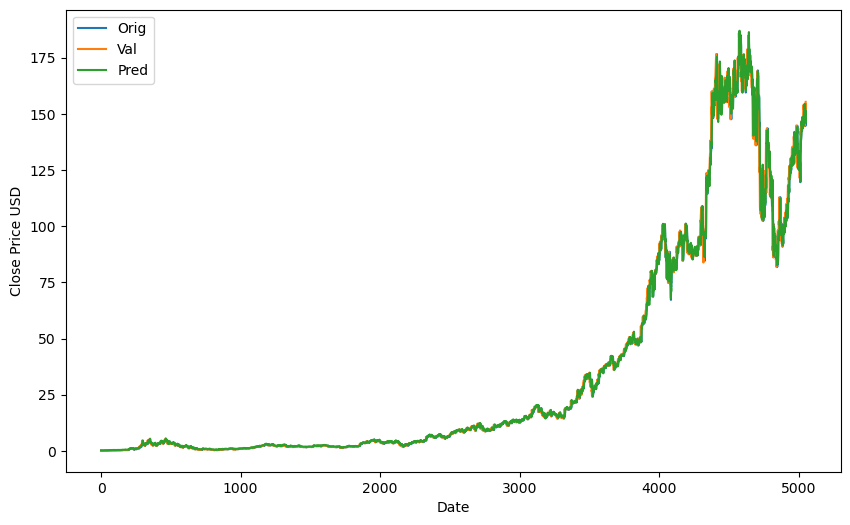

In [371]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df1['Close'])
plt.plot(pandas_df1[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Random Forest Regressor model

In [372]:
from pyspark.ml.regression import RandomForestRegressor

In [373]:
rf=RandomForestRegressor(featuresCol='Features', labelCol='Close')
rf_model=rf.fit(train_data)

Test

In [374]:
pred_test2=rf_model.transform(test_data)
pred_test2.select("Features", "Close", "Future_Close", "Prediction").show()

+--------------------+--------+------------+-----------------+
|            Features|   Close|Future_Close|       Prediction|
+--------------------+--------+------------+-----------------+
|[0.08125,0.081771...|0.076563|    0.082813|0.721822351084666|
|[0.077083,0.07708...| 0.07526|    0.084375|0.721822351084666|
|[0.075521,0.07656...|0.075521|    0.077083|0.721822351084666|
|[0.079688,0.08020...|0.077083|    0.076302|0.721822351084666|
|[0.080208,0.08020...|0.078646|    0.075521|0.721822351084666|
|[0.079948,0.07994...| 0.07526|    0.075521|0.721822351084666|
|[0.076042,0.07682...|0.075521|    0.074479|0.721822351084666|
|[0.075521,0.07656...|0.075521|    0.077083|0.721822351084666|
|[0.076563,0.07760...|0.076302|    0.075781|0.721822351084666|
|[0.079948,0.09583...|0.095573|    0.121875|0.721822351084666|
|[0.091667,0.10104...|     0.1|    0.116667|0.721822351084666|
|[0.126042,0.12604...|0.114583|    0.106771|0.721822351084666|
|[0.106771,0.12395...|0.121875|    0.113021|0.721822351

In [375]:
mse = evaluator.evaluate(pred_test2)
r2 = evaluator_r2.evaluate(pred_test2)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  18.168809100268913 
r2:  0.992944031068276 



In [376]:
pred_test2=pred_test2.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_test2.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  25.57418004603063


In [377]:
pandas_df2 = pred_test2.select("Close", "Future_Close", "Prediction").toPandas()

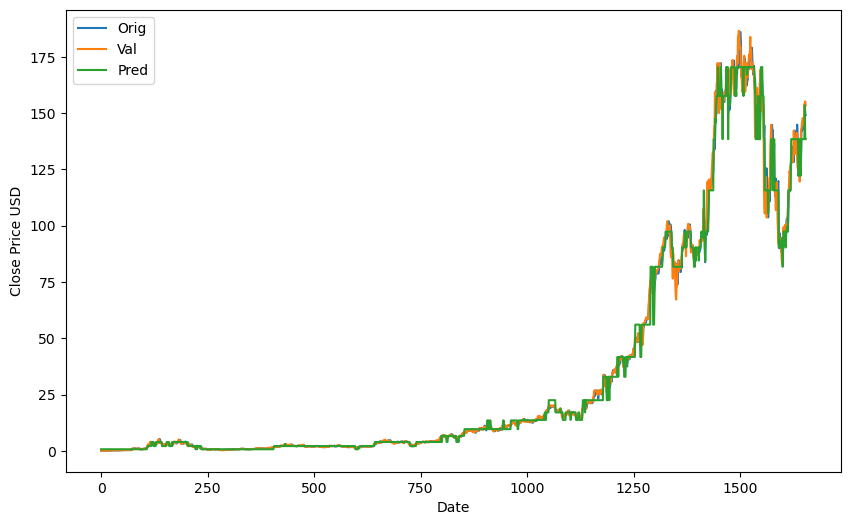

In [378]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df2['Close'])
plt.plot(pandas_df2[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Train

In [379]:
pred_train2=rf_model.transform(train_data)
pred_train2.select("Features", "Close", "Future_Close", "Prediction").show()

+--------------------+--------+------------+-----------------+
|            Features|   Close|Future_Close|       Prediction|
+--------------------+--------+------------+-----------------+
|[0.121875,0.125,0...|0.097917|    0.079167|0.721822351084666|
|[0.098438,0.09895...|0.086458|    0.076563|0.721822351084666|
|[0.088021,0.08854...|0.085417|     0.07526|0.721822351084666|
|[0.086458,0.0875,...|0.081771|       0.075|0.721822351084666|
|[0.081771,0.08229...|0.071354|    0.075521|0.721822351084666|
|[0.071875,0.07239...|0.069792|    0.073958|0.721822351084666|
|[0.070313,0.07604...|   0.075|    0.070833|0.721822351084666|
|[0.075521,0.08229...|0.079167|    0.077083|0.721822351084666|
|[0.075,0.075521,0...|   0.075|    0.079167|0.721822351084666|
|[0.076563,0.07656...|0.073958|    0.080208|0.721822351084666|
|[0.073958,0.07447...|0.070833|    0.079167|0.721822351084666|
|[0.070833,0.07708...|0.077083|    0.078646|0.721822351084666|
|[0.075781,0.08541...|0.082813|     0.07526|0.721822351

In [380]:
mse = evaluator.evaluate(pred_train2)
r2 = evaluator_r2.evaluate(pred_train2)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  18.122943107463232 
r2:  0.9928081621475043 



In [381]:
pred_train2=pred_train2.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_train2.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  23.323379562111075


In [382]:
pandas_df2 = pred_train2.select("Close", "Future_Close", "Prediction").toPandas()

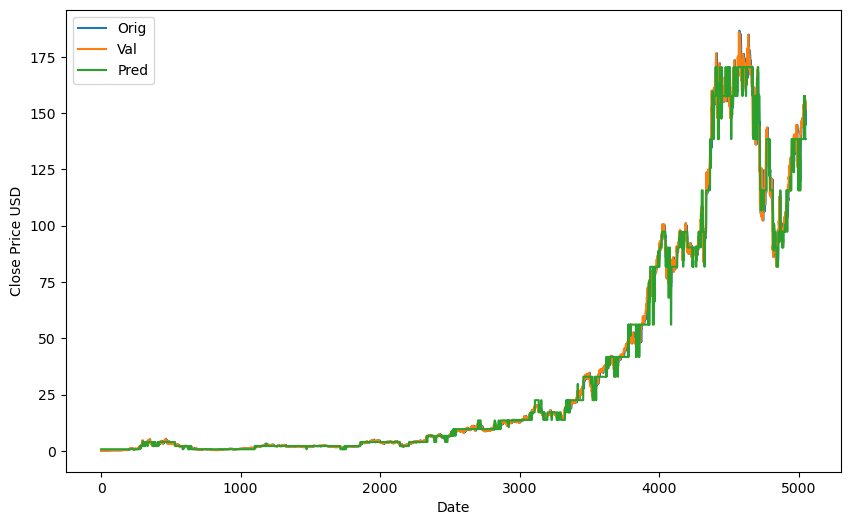

In [383]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df2['Close'])
plt.plot(pandas_df2[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Gradient-Boosted Tree Regression

In [384]:
from pyspark.ml.regression import GBTRegressor

In [385]:
gbt = GBTRegressor(featuresCol='Features', labelCol='Future_Close', maxIter=10)
gbt_model = gbt.fit(train_data)

In [386]:
pred_test3=gbt_model.transform(test_data)
pred_test3.select("Features", "Close", "Future_Close", "Prediction").show(truncate=False)

+----------------------------+--------+------------+------------------+
|Features                    |Close   |Future_Close|Prediction        |
+----------------------------+--------+------------+------------------+
|[0.08125,0.081771,0.076563] |0.076563|0.082813    |0.3015840684398108|
|[0.077083,0.077083,0.073958]|0.07526 |0.084375    |0.3015840684398108|
|[0.075521,0.076563,0.075]   |0.075521|0.077083    |0.3015840684398108|
|[0.079688,0.080208,0.076563]|0.077083|0.076302    |0.3015840684398108|
|[0.080208,0.080208,0.078125]|0.078646|0.075521    |0.3015840684398108|
|[0.079948,0.079948,0.07474] |0.07526 |0.075521    |0.3015840684398108|
|[0.076042,0.076823,0.075]   |0.075521|0.074479    |0.3015840684398108|
|[0.075521,0.076563,0.075]   |0.075521|0.077083    |0.3015840684398108|
|[0.076563,0.077604,0.075]   |0.076302|0.075781    |0.3015840684398108|
|[0.079948,0.095833,0.079688]|0.095573|0.121875    |0.3015840684398108|
|[0.091667,0.101042,0.091667]|0.1     |0.116667    |0.3015840684

In [387]:
mse = evaluator.evaluate(pred_test3)
r2 = evaluator_r2.evaluate(pred_test3)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  18.310926891519536 
r2:  0.9928888387486157 



In [388]:
pred_test3=pred_test3.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_test3.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  12.302890298476711


In [389]:
pandas_df3 = pred_test3.select("Close", "Future_Close", "Prediction").toPandas()

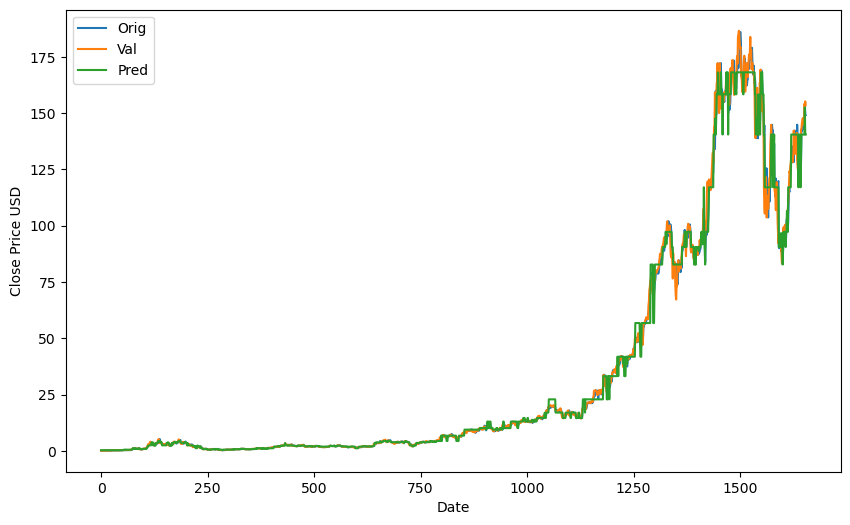

In [390]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df3['Close'])
plt.plot(pandas_df3[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Train

In [391]:
pred_train3=gbt_model.transform(train_data)
pred_train3.select("Features", "Close", "Future_Close", "Prediction").show(truncate=False)

+----------------------------+--------+------------+------------------+
|Features                    |Close   |Future_Close|Prediction        |
+----------------------------+--------+------------+------------------+
|[0.121875,0.125,0.096354]   |0.097917|0.079167    |0.3015840684398108|
|[0.098438,0.098958,0.085417]|0.086458|0.076563    |0.3015840684398108|
|[0.088021,0.088542,0.08125] |0.085417|0.07526     |0.3015840684398108|
|[0.086458,0.0875,0.081771]  |0.081771|0.075       |0.3015840684398108|
|[0.081771,0.082292,0.06875] |0.071354|0.075521    |0.3015840684398108|
|[0.071875,0.072396,0.065625]|0.069792|0.073958    |0.3015840684398108|
|[0.070313,0.076042,0.066667]|0.075   |0.070833    |0.3015840684398108|
|[0.075521,0.082292,0.072917]|0.079167|0.077083    |0.3015840684398108|
|[0.075,0.075521,0.073958]   |0.075   |0.079167    |0.3015840684398108|
|[0.076563,0.076563,0.073958]|0.073958|0.080208    |0.3015840684398108|
|[0.073958,0.074479,0.069792]|0.070833|0.079167    |0.3015840684

In [392]:
mse = evaluator.evaluate(pred_train3)
r2 = evaluator_r2.evaluate(pred_train3)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  17.561333993046148 
r2:  0.9930310289116618 



In [393]:
pred_train3=pred_train3.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_train3.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  11.41385215208757


In [394]:
pandas_df3 = pred_train3.select("Close", "Future_Close", "Prediction").toPandas()

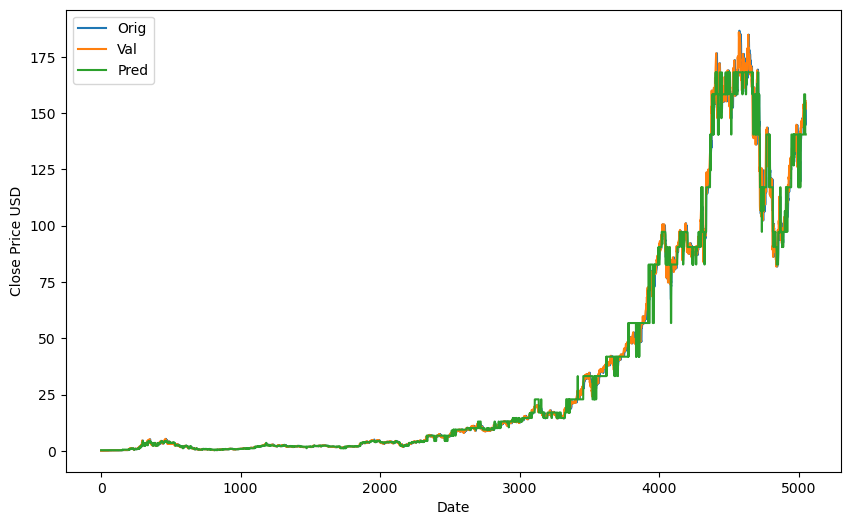

In [395]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df3['Close'])
plt.plot(pandas_df3[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Linear Regression model

In [396]:
pandas_df = pred_train1.select("Close", "Future_Close", "Prediction").toPandas()

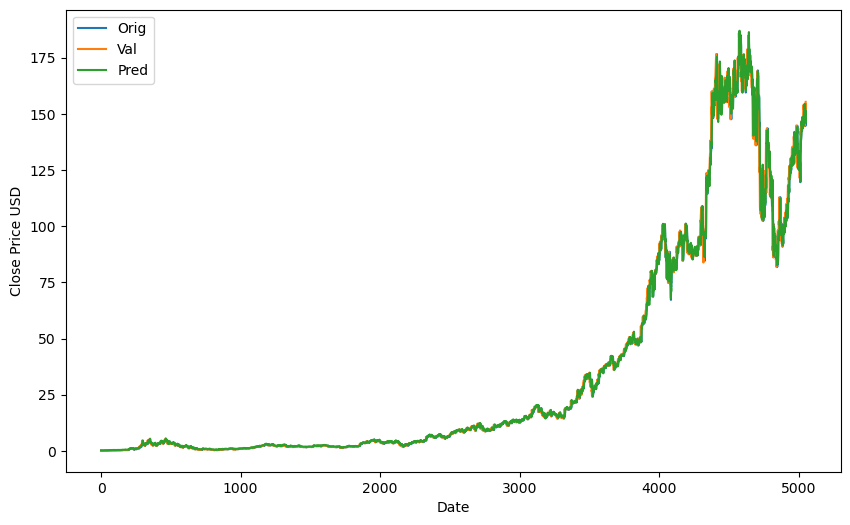

In [397]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df['Close'])
plt.plot(pandas_df[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

In [398]:
# lr_model.write().save("Model")

SONY

In [399]:
data = spark.read.csv('SONY.csv', inferSchema=True, header=True)
data.show()

+----------+---------+---------+---------+---------+---------+-------+
|      Date|     Open|     High|      Low|    Close|Adj Close| Volume|
+----------+---------+---------+---------+---------+---------+-------+
|2012-02-02|    17.65|    17.68|    16.85|    17.09|    17.09|3934600|
|2012-02-03|    18.85|    19.32|18.790001|19.209999|19.209999|4453500|
|2012-02-06|19.360001|19.459999|19.280001|19.440001|19.440001|1322700|
|2012-02-07|19.639999|19.709999|    19.16|    19.68|    19.68|1664400|
|2012-02-08|19.790001|    20.01|19.780001|19.889999|19.889999|1195500|
|2012-02-09|19.940001|     20.0|19.799999|    19.91|    19.91| 885200|
|2012-02-10|19.690001|19.690001|    19.41|19.530001|19.530001|1751000|
|2012-02-13|19.559999|    19.58|19.389999|    19.48|    19.48| 809600|
|2012-02-14|    19.23|    19.23|     19.0|19.129999|19.129999|1245600|
|2012-02-15|19.969999|    20.15|19.950001|    19.99|    19.99|2194900|
|2012-02-16|20.209999|    20.52|20.209999|     20.5|     20.5|1319500|
|2012-

In [400]:
future_days=15
windowSpec = Window.orderBy("Date")
data = data.withColumn("Future_close", lag("Close", -future_days).over(windowSpec))

In [401]:
featureassembler=VectorAssembler(inputCols=["Open", "High", "Low"], outputCol='Features')
data=featureassembler.transform(data)
data = data.na.drop()

In [402]:
sony_prediction=lr_model.transform(data)
sony_prediction.show()

+----------+---------+---------+---------+---------+---------+-------+------------+--------------------+------------------+
|      Date|     Open|     High|      Low|    Close|Adj Close| Volume|Future_close|            Features|        prediction|
+----------+---------+---------+---------+---------+---------+-------+------------+--------------------+------------------+
|2012-02-02|    17.65|    17.68|    16.85|    17.09|    17.09|3934600|       21.73| [17.65,17.68,16.85]|17.205235924083254|
|2012-02-03|    18.85|    19.32|18.790001|19.209999|19.209999|4453500|   21.690001|[18.85,19.32,18.7...|19.352886958499724|
|2012-02-06|19.360001|19.459999|19.280001|19.440001|19.440001|1322700|       22.26|[19.360001,19.459...|19.540570994715843|
|2012-02-07|19.639999|19.709999|    19.16|    19.68|    19.68|1664400|   21.389999|[19.639999,19.709...|19.480484974238717|
|2012-02-08|19.790001|    20.01|19.780001|19.889999|19.889999|1195500|       21.57|[19.790001,20.01,...|20.125138196423926|
|2012-02

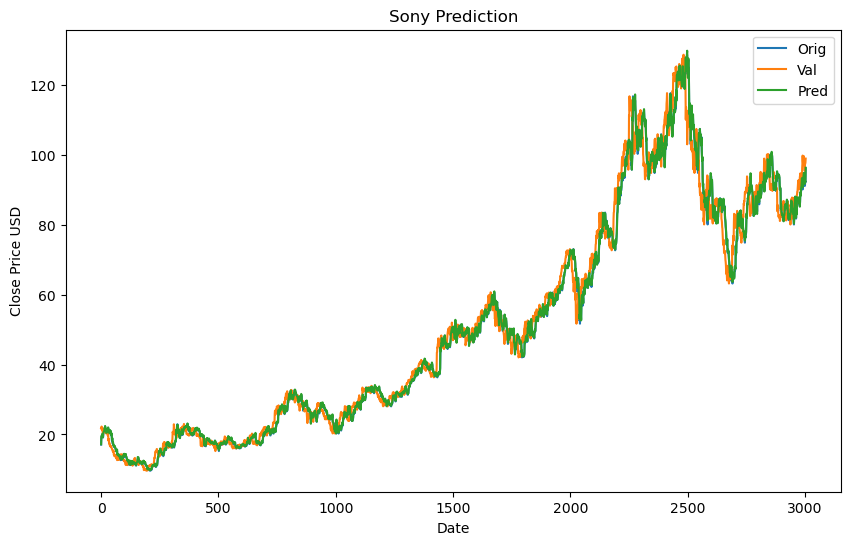

In [403]:
sony_prediction = sony_prediction.select("Close", "Future_Close", "Prediction").toPandas()
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(sony_prediction['Close'])
plt.plot(sony_prediction[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.title('Sony Prediction')
plt.show()